# 1D Offshore Spectrum to Nearshore observations

This version of the code used pytorch

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#handy function for emptying the chached memory in a GPU
#the kernal should be restarted every time this is run
from numba import cuda
cuda.select_device(0)
cuda.close()

### Read in 1d Spectrum

The one dimensional spectrum is stored per timestep in the dataframe, the frequencies don't change.

In [2]:
oneD_Off = pd.read_csv('../data/hindcast_spec.csv', header = 0, index_col = 0, parse_dates = True)
oneD_Off = oneD_Off.apply(pd.to_numeric, errors='coerce')
oneD_Off.index = oneD_Off.index.round('H')

<Axes: >

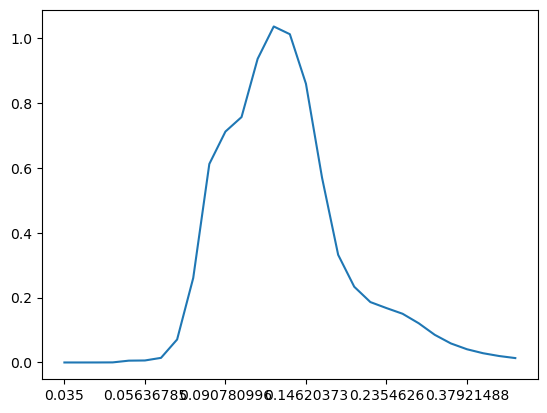

In [3]:
oneD_Off.iloc[300].plot()


We also need to ensure that we have some understanding of direction, so we will read in the offshore wave parameters.

In [4]:
offStats = pd.read_csv("../data/hindcast_offshore_params.csv", index_col = 0 , parse_dates =True )
offStats = offStats.apply(pd.to_numeric, errors='coerce')
offStats.index = offStats.index.round('H')

In [5]:
offStats = offStats.round(2)

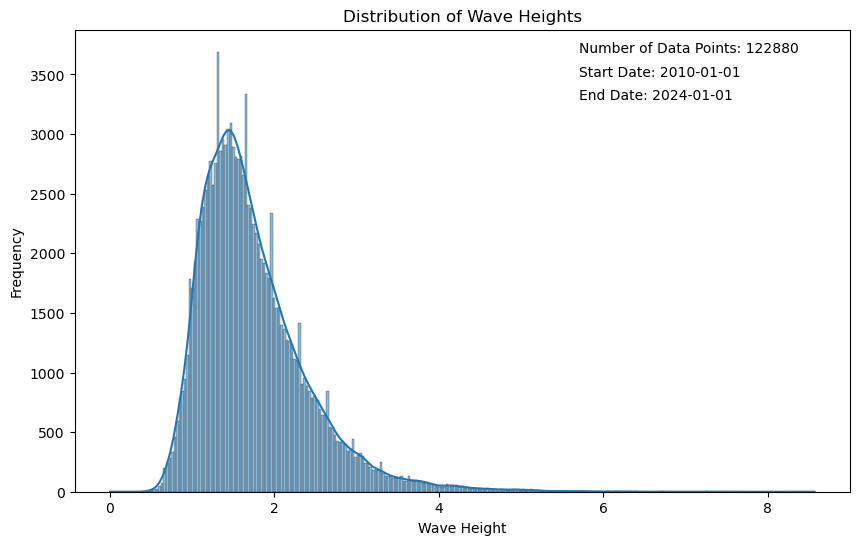

In [6]:
import seaborn as sns

# Create a distribution plot of wave heights
plt.figure(figsize=(10, 6))
sns.histplot(data=offStats, x='hs', kde=True)

# Add notes about the dataset
num_data_points = len(offStats)
start_date = offStats.index[0].strftime('%Y-%m-%d')
end_date = offStats.index[-1].strftime('%Y-%m-%d')
plt.text(0.65, 0.95, f"Number of Data Points: {num_data_points}", transform=plt.gca().transAxes)
plt.text(0.65, 0.9, f"Start Date: {start_date}", transform=plt.gca().transAxes)
plt.text(0.65, 0.85, f"End Date: {end_date}", transform=plt.gca().transAxes)

# Set plot title and labels
plt.title("Distribution of Wave Heights")
plt.xlabel("Wave Height")
plt.ylabel("Frequency")

# Show the plot
plt.show()


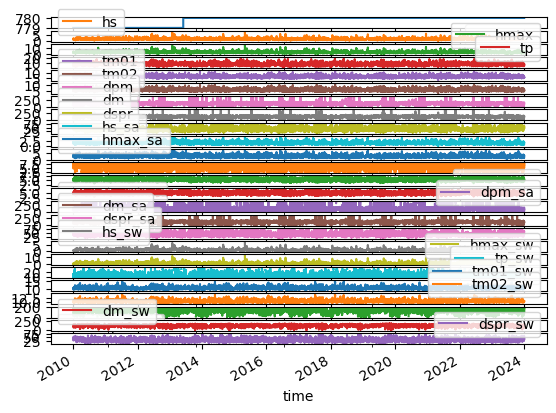

In [7]:
_ = offStats.plot(subplots = True)

In [8]:
start = offStats.sort_index().index[0]
end = offStats.sort_index().index[-1]
len(pd.date_range(start, end, freq='H')) - len(offStats)

-167

In [9]:
len(pd.date_range(start, end, freq='H'))

122713

In [10]:
offStats.drop_duplicates(inplace = True)

## Read in Observational Data

Observational data is available from a number of sources we need to bring them together.

In [11]:
Obs = pd.read_csv('../data/obs_GC.csv', parse_dates = True, index_col = 0)
Obs.columns = ['hs','hmax','tp','tz','dp']
Obs.index = Obs.index - pd.Timedelta(hours=10)

In [12]:
Obs = Obs[Obs['dp']>-1]

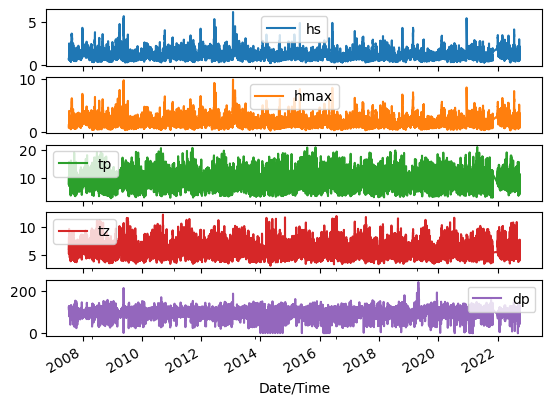

In [13]:
_ = Obs.plot(subplots = True)

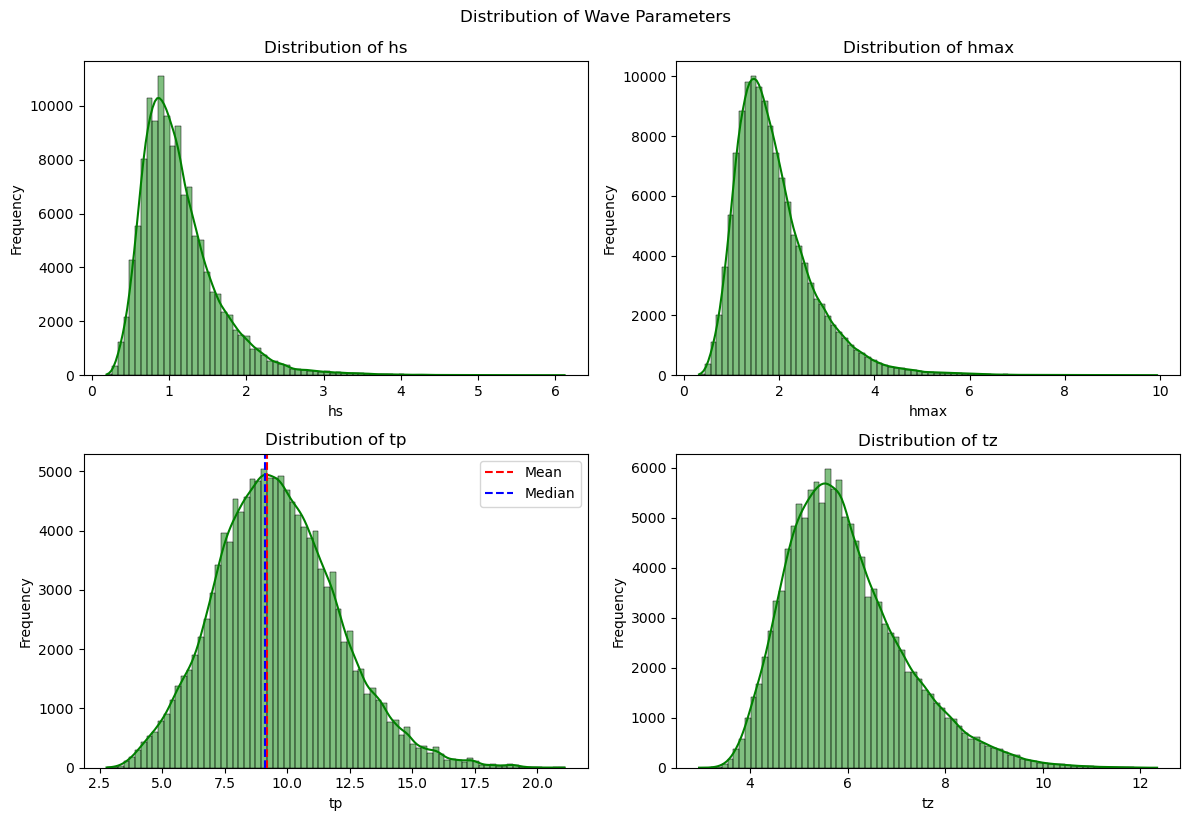

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Plotting hs
sns.histplot(data=Obs, x='hs', bins=80, kde=True, ax=axes[0, 0], color='green')
axes[0, 0].set_title('Distribution of hs')
axes[0, 0].set_xlabel('hs')
axes[0, 0].set_ylabel('Frequency')

# Plotting hmax
sns.histplot(data=Obs, x='hmax', bins=80, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Distribution of hmax')
axes[0, 1].set_xlabel('hmax')
axes[0, 1].set_ylabel('Frequency')



# Plotting tp
sns.histplot(data=Obs, x='tp', bins=80, kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribution of tp')
axes[1, 0].set_xlabel('tp')
axes[1, 0].set_ylabel('Frequency')

# Add matching parameters from offStats dataset
offStats_tp = offStats['tp']
axes[1, 0].axvline(x=offStats_tp.mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].axvline(x=offStats_tp.median(), color='blue', linestyle='--', label='Median')
axes[1, 0].legend()

# Plotting tz
sns.histplot(data=Obs, x='tz', bins=80, kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Distribution of tz')
axes[1, 1].set_xlabel('tz')
axes[1, 1].set_ylabel('Frequency')


# Adjusting the layout
plt.tight_layout()
plt.suptitle('Distribution of Wave Parameters', y=1.02)

# Show the plot
plt.show()


In [15]:
start = Obs.sort_index().index[0]
end = Obs.sort_index().index[-1]
len(pd.date_range(start, end, freq='H')) - len(Obs)

3866

In [16]:
new_columns = [column + '_tgt' for column in Obs.columns]
Obs = Obs.rename(columns=dict(zip(Obs.columns, new_columns)))

In [17]:
merged_df = pd.merge(oneD_Off, offStats, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, Obs, left_index=True, right_index=True)

In [18]:
merged_df = merged_df.sort_index()
merged_df.drop_duplicates(inplace = True)

In [19]:
merged_df.columns

Index(['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364', '0.45885003', '0.50473505', 'site', 'hs',
       'hmax', 'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'hs_sa', 'hmax_sa',
       'tp_sa', 'tm01_sa', 'tm02_sa', 'dpm_sa', 'dm_sa', 'dspr_sa', 'hs_sw',
       'hmax_sw', 'tp_sw', 'tm01_sw', 'tm02_sw', 'dpm_sw', 'dm_sw', 'dspr_sw',
       'hs_tgt', 'hmax_tgt', 'tp_tgt', 'tz_tgt', 'dp_tgt'],
      dtype='object')

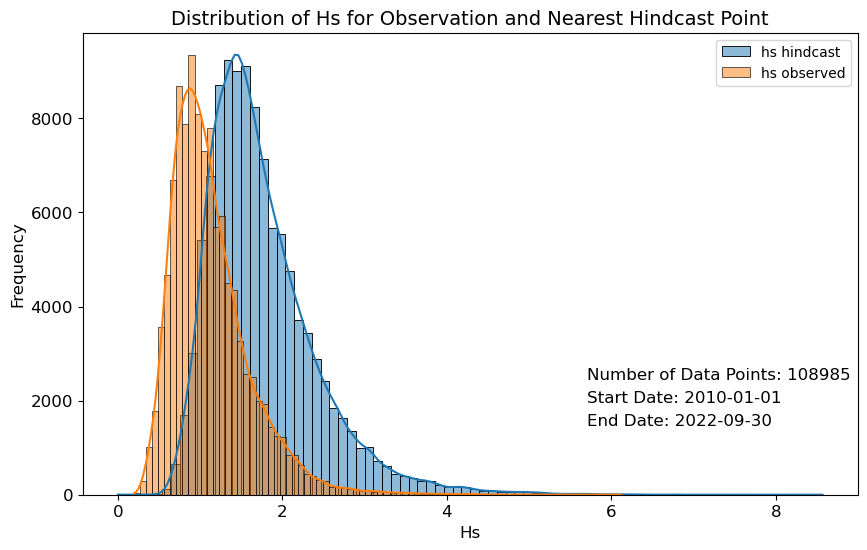

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='hs', kde=True, bins=80, label='hs hindcast')
sns.histplot(data=merged_df, x='hs_tgt', kde=True, bins=80, label='hs observed')

# Add notes about the dataset
num_data_points = len(merged_df)
start_date = merged_df.index[0].strftime('%Y-%m-%d')
end_date = merged_df.index[-1].strftime('%Y-%m-%d')
plt.text(0.65, 0.25, f"Number of Data Points: {num_data_points}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.65, 0.2, f"Start Date: {start_date}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.65, 0.15, f"End Date: {end_date}", transform=plt.gca().transAxes, fontsize=12)

# Set plot title and labels
plt.title("Distribution of Hs for Observation and Nearest Hindcast Point", fontsize=14)
plt.xlabel("Hs", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Increase the font size of the axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.legend()
plt.show()



In [21]:
mycolumns = ['hs','hs_tgt','hmax','hmax_tgt','tp','tp_tgt','tm02','tz_tgt','dpm','dp_tgt']
sublists = [[mycolumns[i], mycolumns[i+1]] for i in range(0, len(mycolumns), 2)]
sublists

[['hs', 'hs_tgt'],
 ['hmax', 'hmax_tgt'],
 ['tp', 'tp_tgt'],
 ['tm02', 'tz_tgt'],
 ['dpm', 'dp_tgt']]

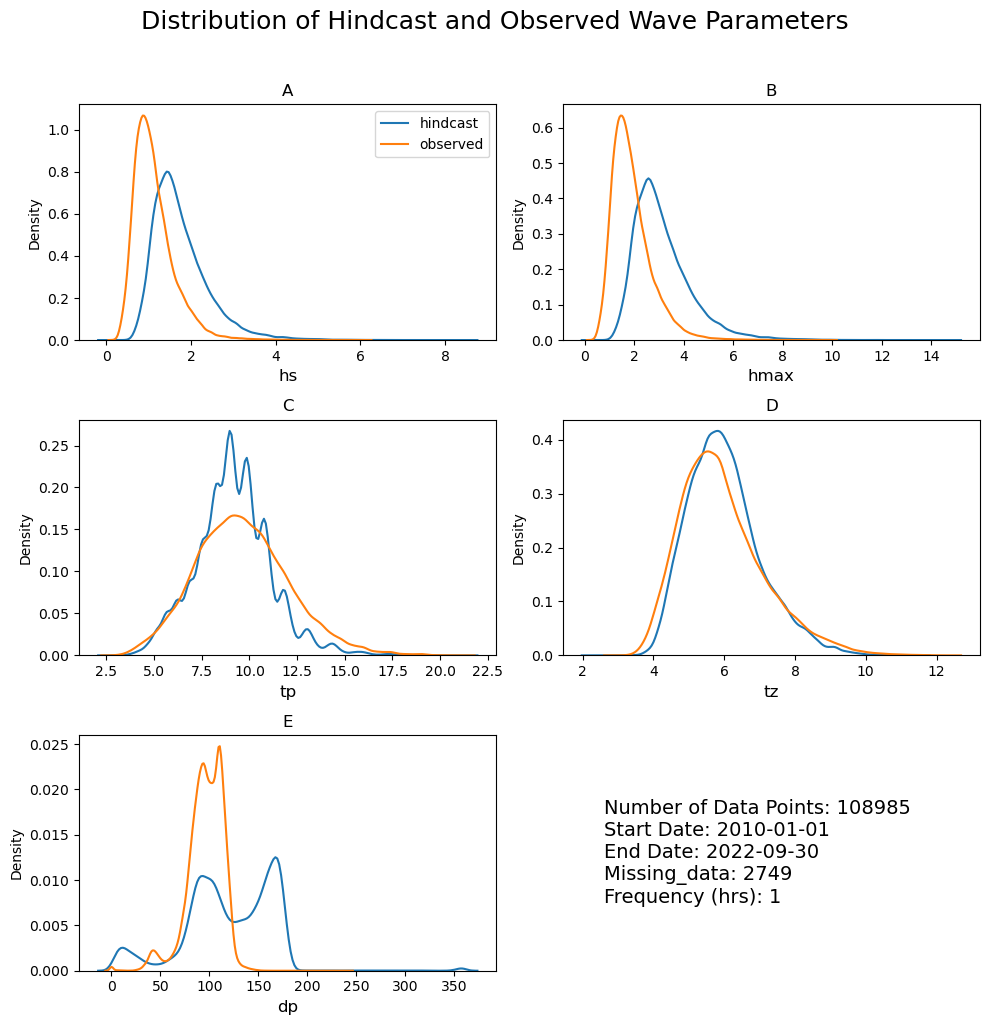

In [22]:
# Calculate the number of rows and columns for subplots
num_rows = 3
num_cols = 2

# Create subplots for distribution plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
plotting_df = merged_df.reset_index(drop=True)

label = ['A','B','C','D','E']

# Iterate over each pair of column names
for i, column in enumerate(sublists):
    row = i // num_cols
    col = i % num_cols
    
    # Create distribution plots for each pair of columns
    sns.kdeplot(data=plotting_df, x=column[0], ax=axes[row, col], label='hindcast')
    sns.kdeplot(data=plotting_df, x=column[1], ax=axes[row, col], label='observed')
    
    # Set titles and labels for each subplot
    #axes[row, col].set_title(f"Distribution of hindcast and observed {column[1].split('_')[0]}")
    axes[row, col].set_xlabel(column[1].split('_')[0], fontsize = 12)
    axes[row, col].set_ylabel("Density")
    axes[row, col].set_title(f"{label[i]}")

axes[2,1].axis('off')
axes[0,0].legend()
#axes[2,1].annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5), xycoords='axes fraction', va='center')

# Add annotation for number of data points and start/end date
num_data_points = len(merged_df)
start_date = merged_df.index[0].strftime('%Y-%m-%d')
end_date = merged_df.index[-1].strftime('%Y-%m-%d')
missingdata = str(len(pd.date_range(merged_df.index[0], merged_df.index[-1], freq='H')) - len(merged_df))
freq = str((merged_df.index[-1]-merged_df.index[-2]).components.hours)
axes[2,1].annotate(f"Number of Data Points: {num_data_points}\nStart Date: {start_date}\nEnd Date: {end_date}\nMissing_data: {missingdata}\nFrequency (hrs): {freq}", xy=(0.1, 0.5), xycoords='axes fraction', va='center', fontsize=14)

plt.suptitle("Distribution of Hindcast and Observed Wave Parameters", y=1.02, fontsize=18)

# Adjust the layout
plt.tight_layout()
#plt.savefig('./Plots/distribution_of_hindcast_and_observed_wave_parameters.png')
# Show the plots
plt.show()


## Feature Engineering

**Time Based**

In [23]:
def feature_engineering_time_series(data):
    # Extracting features from the DateTimeIndex
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Adding cyclic timing features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Additional feature engineering steps can be added here
    
    return data

In [24]:
merged_df = feature_engineering_time_series(merged_df)

**Direction Based**

In [25]:
def feature_engineering_wave_direction(data, direction_columns):
    for column in direction_columns:
        # Creating circular features for wave direction
        data[f'{column}_sin'] = np.sin(np.radians(data[column]))
        data[f'{column}_cos'] = np.cos(np.radians(data[column]))
        
        # Removing the original column
        data.drop(column, axis=1, inplace=True)
    
    
    return data

In [26]:
merged_df.columns

Index(['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364', '0.45885003', '0.50473505', 'site', 'hs',
       'hmax', 'tp', 'tm01', 'tm02', 'dpm', 'dm', 'dspr', 'hs_sa', 'hmax_sa',
       'tp_sa', 'tm01_sa', 'tm02_sa', 'dpm_sa', 'dm_sa', 'dspr_sa', 'hs_sw',
       'hmax_sw', 'tp_sw', 'tm01_sw', 'tm02_sw', 'dpm_sw', 'dm_sw', 'dspr_sw',
       'hs_tgt', 'hmax_tgt', 'tp_tgt', 'tz_tgt', 'dp_tgt', 'year', 'month',
       'day', 'day_of_week', 'hour', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [27]:
dp_col = list(merged_df.columns[merged_df.columns.str.contains('Dir_Tp TRUE_tgt')])
dpm_col = list(merged_df.columns[merged_df.columns.str.contains('dpm')])
dm_col = list(merged_df.columns[merged_df.columns.str.contains('dm')])

In [28]:
merged_df = feature_engineering_wave_direction(merged_df, dpm_col + dm_col + dp_col)

In [29]:
merged_df['hs+3'] = merged_df['hs'].shift(3)
merged_df['hs+6'] = merged_df['hs'].shift(6)
merged_df['hs+12'] = merged_df['hs'].shift(12)
merged_df['hs+24'] = merged_df['hs'].shift(24)

In [30]:
#merged_df.dropna(inplace = True)

In [31]:
#merged_df = merged_df.iloc[::2, :] #make 3 hourly

In [32]:
len(merged_df)

108985

In [33]:
ind_data = merged_df["2020-01-01":]
merged_df  = merged_df[:"2020-01-01"]

## Selecting Training Data

In [34]:
merged_df.columns

Index(['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364', '0.45885003', '0.50473505', 'site', 'hs',
       'hmax', 'tp', 'tm01', 'tm02', 'dspr', 'hs_sa', 'hmax_sa', 'tp_sa',
       'tm01_sa', 'tm02_sa', 'dspr_sa', 'hs_sw', 'hmax_sw', 'tp_sw', 'tm01_sw',
       'tm02_sw', 'dspr_sw', 'hs_tgt', 'hmax_tgt', 'tp_tgt', 'tz_tgt',
       'dp_tgt', 'year', 'month', 'day', 'day_of_week', 'hour', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'dpm_sin', 'dpm_cos', 'dpm_sa_sin', 'dpm_sa_cos',
       'dpm_sw_sin', 'dpm_sw_cos', 'dm_sin', 'dm_cos', 'dm_sa_sin',
       'dm_sa_cos', 'dm_sw_sin', 'dm

In [35]:
features_col = ['0.035', '0.0385', '0.042349998', '0.046585', '0.051243503',
       '0.05636785', '0.062004633', '0.068205096', '0.07502561', '0.082528174',
       '0.090780996', '0.099859096', '0.10984501', '0.120829515', '0.13291247',
       '0.14620373', '0.1608241', '0.17690653', '0.19459718', '0.21405691',
       '0.2354626', '0.25900885', '0.28490975', '0.31340075', '0.3447408',
       '0.37921488', '0.4171364',  '0.45885003', '0.50473505', 'dm_sa_sin','dm_sw_sin']
#'dm_sa_sin','dm_sw_sin','hour_sin','hs','hs_sw','hs_sa','tp'

In [36]:
labels_col = ['hs_tgt']

In [37]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [39]:
from sklearn.model_selection import TimeSeriesSplit

In [40]:
T = 12                   #Number of timesteps to look while predicting
D = features.shape[1]   #Dimensionality of the input
N = len(features) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 12 × 31 × 86784


In [41]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [42]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = features[t:t+T]
  y_train[t] = (labels[t+T])

In [43]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = features[t:t+T]
  y_test[i] = (labels[t+T])

## Pytorch Data Preparation

In [44]:
import torch
import torch.nn as nn

In [45]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

## Construct simple LTSM

In [47]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    
    return out


For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 25,000> and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [48]:
model = LSTM(D, 256, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(31, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [49]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=250):

  # Loss and optimizer
  criterion = nn.MSELoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  loser = 1
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    
    
    if (epoch + 1) % 30 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
      checkpoint(model, "best_model_v2.pth")
      #evaluate
      if loser > test_loss.item():
        print(f'current test best = {loser:.3f}, current test loss is: {test_loss.item():.3f}')
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')
        loser = test_loss.item()
        continue
      else:
        break
  return train_losses, test_losses

To do: 
- We need to add better early stopping approach that works on a per epoch and is wise enough to give 5 or more epochs before using the best one
- Need to test alternative learning rates, results seem to vary wildly depending on the learning rate.

## Train the Model

In [50]:

# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=300)

At epoch 30 of 300, Train Loss: 0.051, Test Loss: 0.046
current test best = 1.000, current test loss is: 0.046
At epoch 30 of 300, Train Loss: 0.051, Test Loss: 0.046
At epoch 60 of 300, Train Loss: 0.032, Test Loss: 0.031
current test best = 0.046, current test loss is: 0.031
At epoch 60 of 300, Train Loss: 0.032, Test Loss: 0.031
At epoch 90 of 300, Train Loss: 0.029, Test Loss: 0.030
current test best = 0.031, current test loss is: 0.030
At epoch 90 of 300, Train Loss: 0.029, Test Loss: 0.030
At epoch 120 of 300, Train Loss: 0.027, Test Loss: 0.030


Find the best model from the training and load that in over the top of the latest one!

In [51]:
resume(model, "best_model_v2.pth")

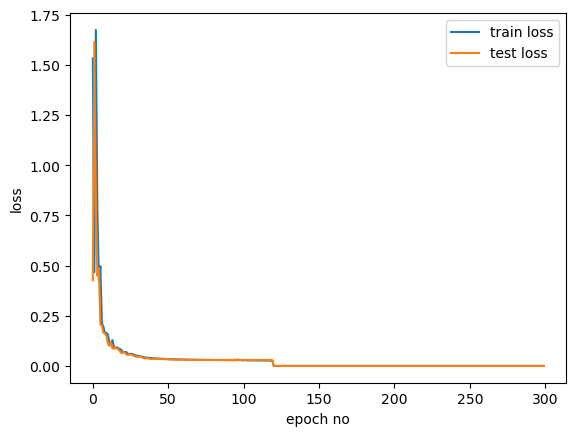

In [52]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()
     

## Assess performance against test data

In [53]:

#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)
  

In [54]:

plot_len = len(test_predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.head(5)

,hs_tgt,prediction
2017-12-27 13:00:00,0.97,0.790296
2017-12-27 14:00:00,0.90,0.785921
2017-12-27 15:00:00,0.81,0.777453
2017-12-27 16:00:00,0.82,0.768300
2017-12-27 17:00:00,0.79,0.762406


Text(0, 0.5, 'Hs (m)')

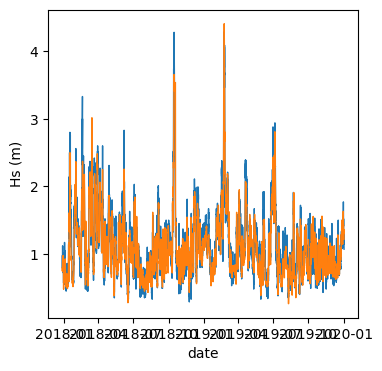

In [55]:
fig = plt.figure(figsize = (4, 4))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


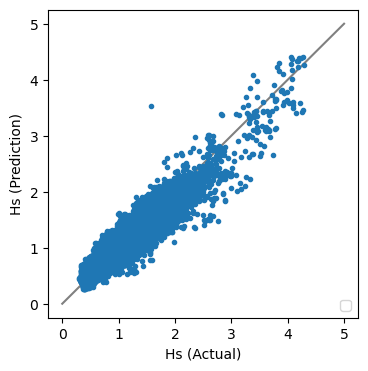

In [56]:
fig = plt.figure(figsize = (4, 4))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

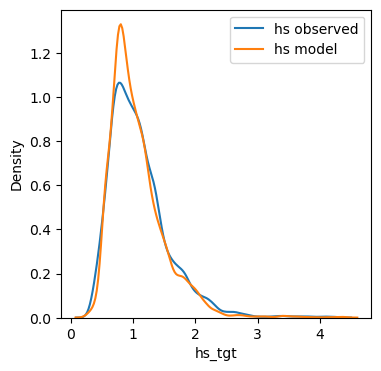

In [57]:
plt.figure(figsize=(4, 4))
sns.kdeplot(data=plot_df, x='hs_tgt', label='hs observed')
sns.kdeplot(data=plot_df, x='prediction', label='hs model')
plt.legend()

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in a short-period of time or picking out the extremes.

In [78]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

Mean square error is: 0.048


Text(0.5, 1.0, 'Distribution of Differences')

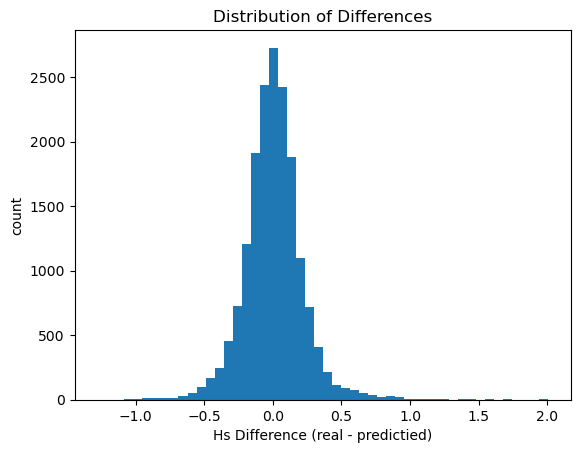

In [79]:
plt.hist(LTSM_error['error'], bins=50)
plt.xlabel('Hs Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

## Test against independent data

The training dataset has gaps due to observations, so for the independent dataset we will gather everything to get a better understanding of performance.

In [58]:
features_ind = scaler.transform(ind_data[features_col].values)

In [59]:
N = len(ind_data) - T
#need to remove this step.... and adjust code below
ind_size = T

# Preparing X_test and y_test
X_ind = np.zeros((N - ind_size, T, D))

for i in range(N - ind_size):
  t = i + ind_size
  X_ind[i, :, :] = features_ind[t:t+T]


In [60]:
X_ind = torch.from_numpy(X_ind.astype(np.float32))

X_ind = X_ind.to(device)

In [61]:
X_ind[i].shape

torch.Size([12, 31])

In [62]:
ind_predictions = []
for i in range(len(X_ind)):
  input_ = X_ind[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  ind_predictions.append(p)

In [63]:
len(ind_predictions)

22189

In [64]:

plot_len = len(ind_predictions)
plot_df = ind_data[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = ind_predictions
plot_df['prediction'] = plot_df['prediction'].shift(1)
plot_df.dropna(inplace = True)
plot_df.head(5)

,hs_tgt,prediction
2020-01-02 01:00:00,1.02,1.209936
2020-01-02 02:00:00,1.04,1.200059
2020-01-02 03:00:00,1.04,1.194639
2020-01-02 04:00:00,1.04,1.189582
2020-01-02 05:00:00,1.12,1.179975


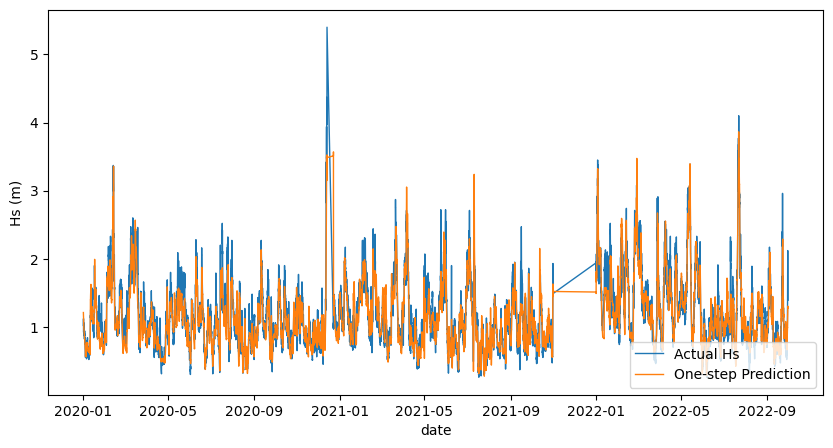

In [65]:
fig = plt.figure(figsize = (10, 5))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')
plt.legend(loc='lower right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


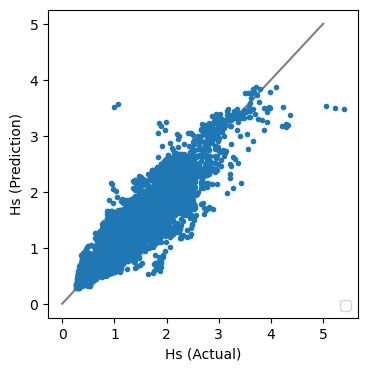

In [66]:
fig = plt.figure(figsize = (4, 4))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], '.')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

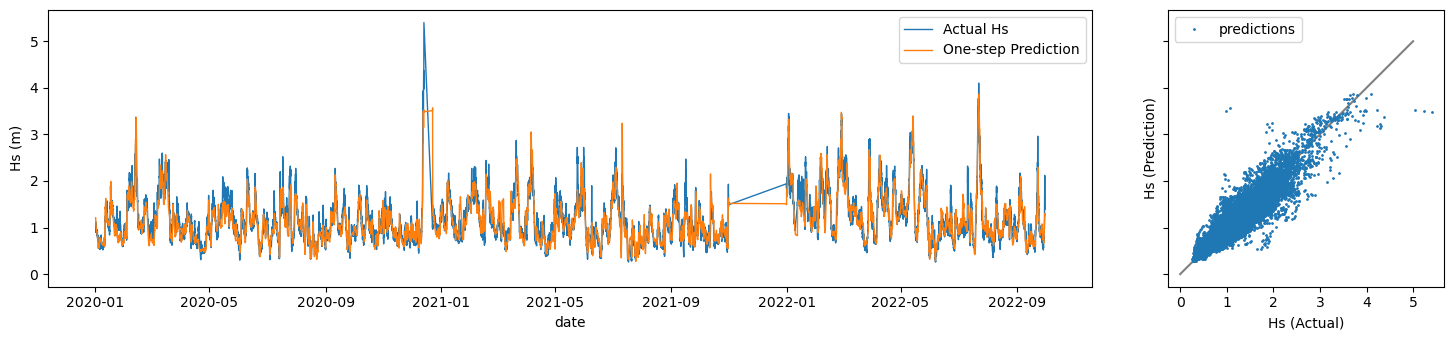

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis

# Line timeseries plot
ax1.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
ax1.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
ax1.set_xlabel('date')
ax1.set_ylabel('Hs (m)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([0, 5], [0, 5], color='grey')
ax2.plot(plot_df[labels_col].values, plot_df['prediction'], '.', markersize=2, label='predictions')
ax2.set_xlabel('Hs (Actual)')
ax2.set_ylabel('Hs (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

plt.tight_layout()
#plt.savefig('./plots/independent_data_prediction.png', dpi=300, bbox_inches='tight')


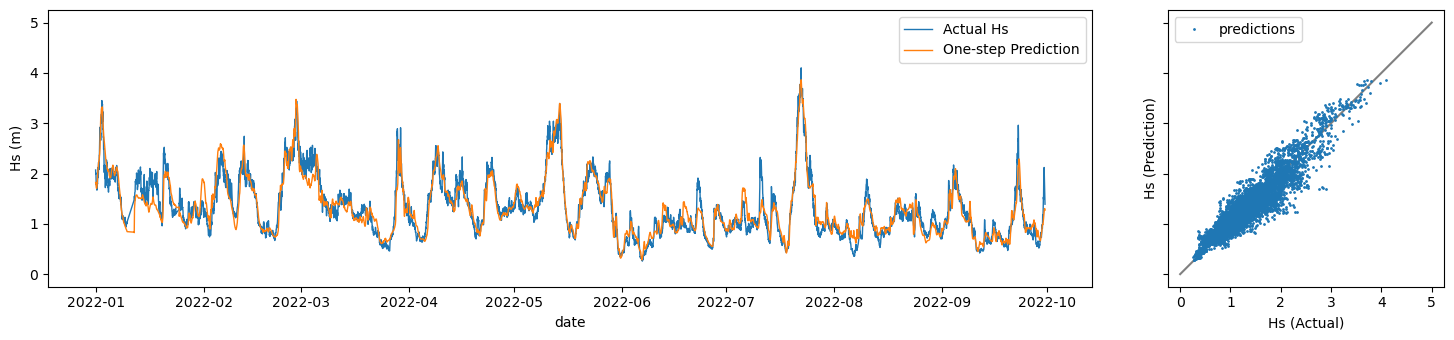

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis

start = '2022-01-01'

# Line timeseries plot
ax1.plot(plot_df[labels_col].loc[start:], label='Actual Hs', linewidth=1)
ax1.plot(plot_df['prediction'].loc[start:], label='One-step Prediction', linewidth=1)
ax1.set_xlabel('date')
ax1.set_ylabel('Hs (m)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([0, 5], [0, 5], color='grey')
ax2.plot(plot_df[labels_col].loc[start:].values, plot_df['prediction'].loc[start:], '.', markersize=2, label='predictions')
ax2.set_xlabel('Hs (Actual)')
ax2.set_ylabel('Hs (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

plt.tight_layout()
#plt.savefig('./plots/independent_data_prediction.png', dpi=300, bbox_inches='tight')

In [70]:
##plot_df.to_csv('../data/LSTM_1DSpec_predictions.csv')

In [71]:
import cal_stats
cal_stats.all_stats(plot_df['prediction'].values, plot_df[labels_col].values.flatten())

{'Bias': -0.02,
 'Root Mean Squared Error': 0.2,
 'Scatter Index': 17.3,
 'Coefficient of Determination': 0.84,
 'Coefficient of Efficiency': 0.84,
 'Correlation Coefficient': 0.92,
 'Index of Agreement': 0.95}

In [72]:
import cal_stats
cal_stats.all_stats(plot_df['prediction'].loc[start:].values, plot_df[labels_col].loc[start:].values.flatten())

{'Bias': -0.0,
 'Root Mean Squared Error': 0.21,
 'Scatter Index': 15.7,
 'Coefficient of Determination': 0.88,
 'Coefficient of Efficiency': 0.87,
 'Correlation Coefficient': 0.94,
 'Index of Agreement': 0.97}

## Machine Learning (Sea and Swell Partitions)

In [73]:
from sklearn.neural_network import MLPRegressor
import pickle

In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [150]:
#features_col = ['hs',
#       'hmax', 'tp', 'tm02','hs_sa', 'hmax_sa',
#       'tm02_sa', 'hs_sw', 'hmax_sw', 'tm01_sw',
#       'tm02_sw','hour_sin','dpm_sin','dm_sin', 'dm_sa_sin', 'dm_sw_sin', ]

features_col = ['hs', 'dm_sin']

In [151]:
features = merged_df[features_col].values
labels = merged_df[labels_col].values

In [152]:
from sklearn.preprocessing import StandardScaler
#Train size: 80% of the total data size
train_size = int(len(features) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(features[:train_size + T - 1])
features = scaler.transform(features)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [154]:
clf_mlp2 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [155]:
clf_mlp2.fit(X_train, y_train.ravel())

MLPRegressor(early_stopping=True, hidden_layer_sizes=(6, 6, 6, 6, 6, 6),
             random_state=0, shuffle=False)

In [156]:
ind_data_clip = ind_data[features_col].dropna().copy()


#### Make Predictions

In [157]:
features_ind = scaler.transform(ind_data_clip.values)

In [158]:
clf_mlp2.predict(features_ind)

array([1.29927482, 1.308203  , 1.31689264, ..., 1.40528474, 1.40408496,
       1.41307723])

In [159]:
part_pred = pd.DataFrame(clf_mlp2.predict(features_ind), index = ind_data_clip.index, columns = ['hs'])

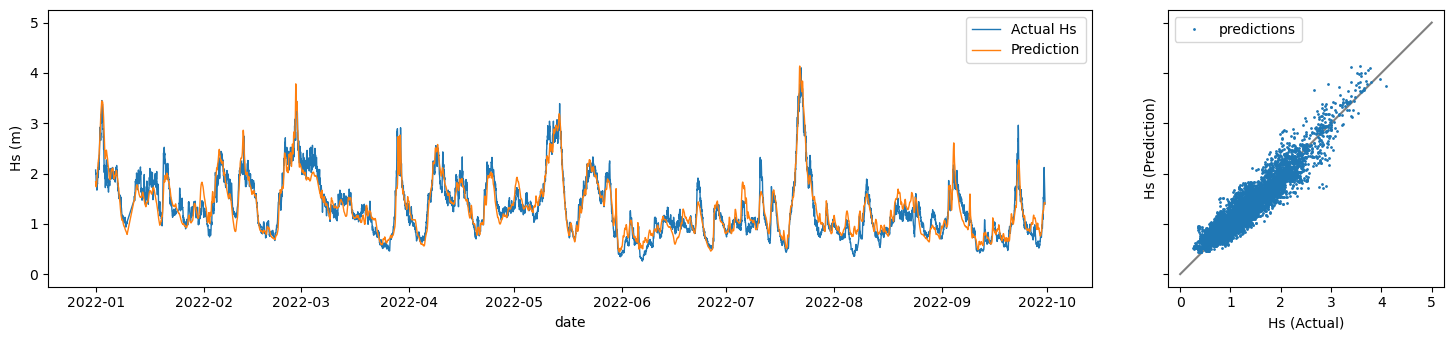

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)  # Increase the width of the figure, adjust the width ratios, and share the y-axis

start = '2022-01-01'

# Line timeseries plot
ax1.plot(ind_data[labels_col].loc[start:], label='Actual Hs', linewidth=1)
ax1.plot(part_pred.loc[start:], label='Prediction', linewidth=1)
ax1.set_xlabel('date')
ax1.set_ylabel('Hs (m)')
ax1.legend(loc='upper right')

# Scatter plot
ax2.plot([0, 5], [0, 5], color='grey')
ax2.plot(ind_data[labels_col].loc[start:].values, part_pred.loc[start:], '.', markersize=2, label='predictions')
ax2.set_xlabel('Hs (Actual)')
ax2.set_ylabel('Hs (Prediction)')
ax2.legend(loc='upper left')
ax2.set_aspect('equal')  # Set aspect ratio to 'equal'

plt.tight_layout()

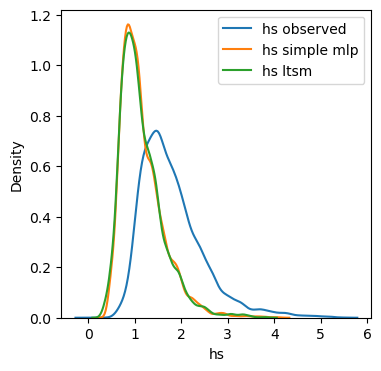

In [161]:
fig = plt.figure(figsize = (4, 4))
sns.kdeplot(data=ind_data, x='hs', label='hs observed')
sns.kdeplot(data=part_pred, x='hs', label='hs simple mlp')
sns.kdeplot(data=plot_df, x='prediction', label='hs ltsm')
plt.legend()

In [162]:
cal_stats.all_stats(part_pred.loc[start:].values.flatten(), ind_data[labels_col].loc[start:].values.flatten())

{'Bias': 0.01,
 'Root Mean Squared Error': 0.21,
 'Scatter Index': 15.6,
 'Coefficient of Determination': 0.88,
 'Coefficient of Efficiency': 0.88,
 'Correlation Coefficient': 0.94,
 'Index of Agreement': 0.97}

# Compare to a simple xboost model

In [ ]:
import xgboost as xgb

In [ ]:
features.shape

(17369, 34)

In [ ]:
labels.shape

(17369, 1)

In [ ]:
# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

train_X, test_X = features[:train_size], features[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

# Fit the model
model.fit(train_X, train_y, eval_set=[(test_X, test_y)], verbose=False)

# Make predictions
predictions = model.predict(test_X)


In [ ]:
plot_len = len(predictions)
plot_df = merged_df[labels_col].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = predictions
plot_df.head(5)

,hs_tgt,prediction
2017-03-16 23:00:00,1.71,1.036096
2017-03-17 03:00:00,1.38,1.189543
2017-03-17 08:00:00,1.46,1.121853
2017-03-17 12:00:00,1.38,1.009145
2017-03-17 17:00:00,1.39,1.142602


Text(0, 0.5, 'Hs (m)')

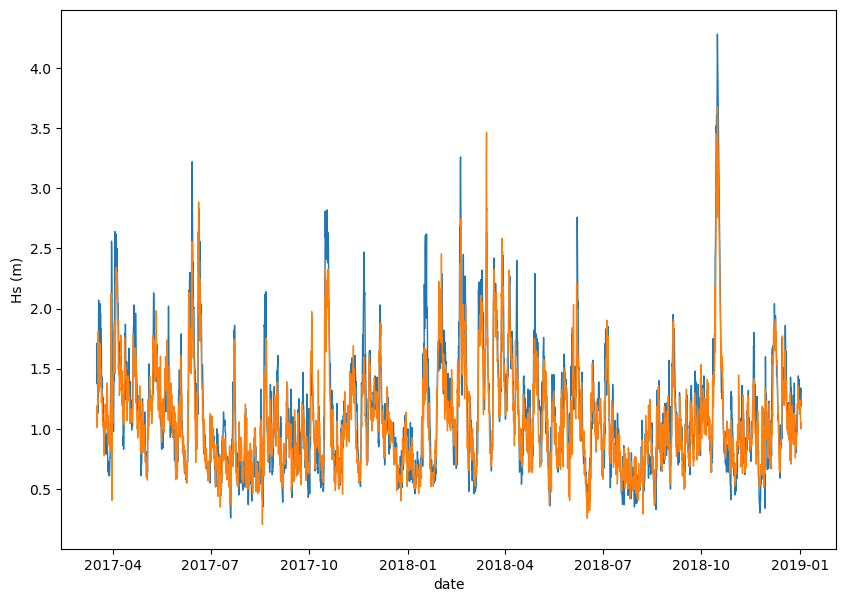

In [ ]:
fig = plt.figure(figsize = (10, 7))
plt.plot(plot_df[labels_col], label='Actual Hs', linewidth=1)
plt.plot(pd.DataFrame(predictions, index = plot_df.index), label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Hs (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


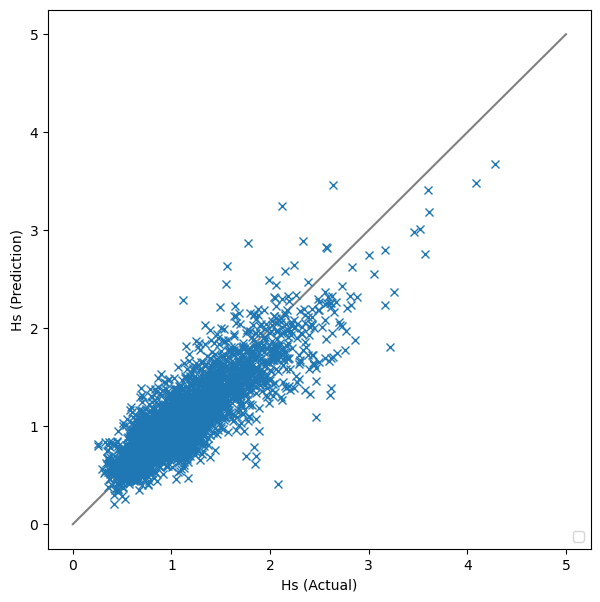

In [ ]:
fig = plt.figure(figsize = (7, 7))
plt.plot([0,5], [0,5], color = 'grey')
plt.plot(plot_df[labels_col].values, plot_df['prediction'], 'x')
plt.xlabel('Hs (Actual)')
plt.ylabel('Hs (Prediction)')
plt.legend(loc='lower right')

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

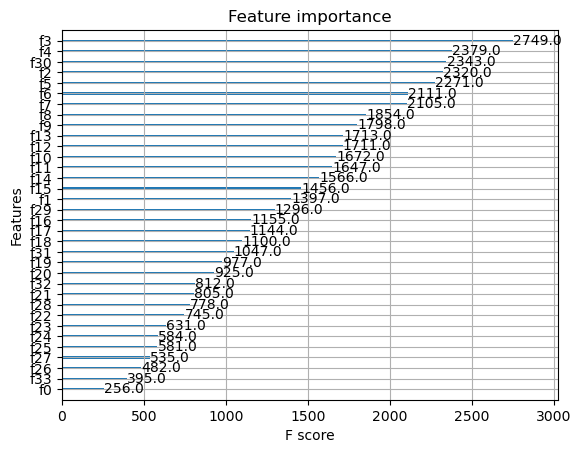

In [ ]:
plot_importance(model)
pyplot.show()

In [ ]:
cal_stats.all_stats(plot_df['prediction'].values, plot_df[labels_col].values.flatten())

{'Bias': -0.05,
 'Root Mean Squared Error': 0.25,
 'Scatter Index': 22.1,
 'Coefficient of Determination': 0.74,
 'Coefficient of Efficiency': 0.73,
 'Correlation Coefficient': 0.86,
 'Index of Agreement': 0.92}